In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

/home/users/zys/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
PLT_CELL = 3.5

In [3]:
np.random.seed(0)
# set up simulation parameters
A_true = np.zeros((8, 8))
d = A_true.shape[0]
N = 100
sigma = np.eye(d)*0.05
for i in range(A_true.shape[0]):
    A_true[i, (i+1) % d] = 1
A_true[-1, 0] = -1
A_true = 1.25*(A_true - np.eye(d))

In [4]:
A_true

array([[-1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25],
       [-1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25]])

In [5]:
np.real(np.linalg.eigvals(A_true))

array([-2.40484942, -2.40484942, -1.72835429, -1.72835429, -0.77164571,
       -0.77164571, -0.09515058, -0.09515058])

In [6]:
import sys
sys.path.append("../src/")
import util
import seaborn as sb

Text(0.5, 1.0, '$A$')

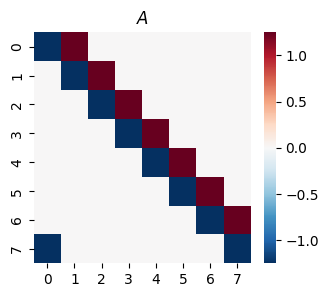

In [7]:
import importlib
importlib.reload(util)
T = 10
t1 = 10
dt = 0.01
ts = np.linspace(0, t1, T)
x0 = (np.arange(d) == 0) * 0.25
# knockouts
kos = []
Ms = [np.ones((d, d), ), ]
ko_label = ["wt", ]
for i in kos:
    M = np.ones((d, d))
    M[:, i] = 0
    Ms.append(M)
    ko_label.append(str(i))
kos = [None, ] + [str(i) for i in kos]
# simulate WT and all knockouts
xs = []
for M in Ms:
    xs.append(util.simulate(A_true * M, sigma, N, ts, lambda N, d: x0 + np.random.randn(N, d)*0.05))
xs = np.stack(xs)

plt.figure(figsize = (3.5, 3))
sb.heatmap(A_true, cmap = "RdBu_r")
plt.title("$A$")

In [116]:
A_true

array([[-1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25,  1.25],
       [-1.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.25]])

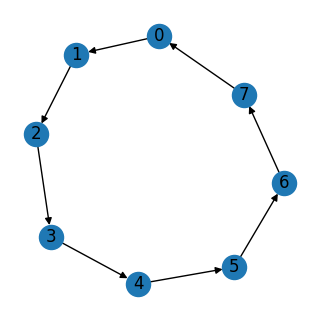

In [117]:
import networkx as nx
_A = A_true.copy()
np.fill_diagonal(_A, 0)
g = nx.DiGraph(np.abs(_A))
centralities = nx.centrality.eigenvector_centrality(g)
plt.figure(figsize = (3, 3))
nx.draw(g, with_labels = True)

In [118]:
import sklearn as sk
from sklearn import decomposition
pca_op = sk.decomposition.PCA(n_components = d)
pca_op.fit(xs.reshape(-1, d))
ys = pca_op.transform(xs.reshape(-1, d)).reshape(xs.shape)

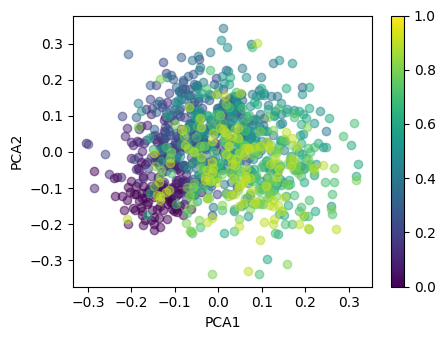

In [122]:
from matplotlib import cm, colors
norm = colors.Normalize(vmin = 0, vmax = T)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.figure(figsize = (4/3*PLT_CELL, PLT_CELL))
for j in range(T):
    plt.scatter(ys[0, j, :, 0], ys[0, j, :, 1], alpha = 0.5, color = m.to_rgba(j))
cb = plt.colorbar()
cb.solids.set(alpha=1)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.tight_layout()
plt.savefig("../figures/OU_8D_snapshots.pdf")

In [12]:
import sys
sys.path.append("../src/")
import importlib
import rf
importlib.reload(rf)
import torch

In [13]:
adatas = [ad.AnnData(np.vstack(xs[i, ...]), {"t" : np.hstack([np.repeat(i, x.shape[0]) for (i, x) in enumerate(xs[i, ...])])}) for i in range(xs.shape[0])]

In [14]:
centralities = pd.Series(centralities)
ko_genes = centralities.index[np.argsort(np.array(centralities))[::-1]][:0]

ko_idx = [np.where(np.array(kos) == None)[0][0], ]
for x in ko_genes:
    try:
        ko_idx.append(np.where(np.array(kos) == str(x))[0][0])
    except:
        pass
[kos[i] for i in ko_idx]

[None]

In [15]:
options = {
    "lr" : 0.25, 
    "reg_sinkhorn" : 0.1,
    "reg_A" : 0.00001, 
    "reg_A_elastic" : 0, 
    "iter" : 1000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam
}
estim_alt = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = True,
                           optimizer = options["optimizer"])
estim_alt.fit(print_iter=100, alg = "alternating");

/home/groups/xiaojie/zys/referencefitting/notebooks/../src/rf.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)
/home/groups/xiaojie/zys/referencefitting/notebooks/../src/rf.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.b, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -0.019086063771867914, L = -0.019086063771867914, R = 0.0
iteration 100, loss = -0.02873332530561839, L = -0.029409801259812424, R = 67.64759541940363
iteration 200, loss = -0.029248437218007937, L = -0.030091279262375408, R = 84.2842044367472
iteration 300, loss = -0.029443564022956992, L = -0.03032382515469682, R = 88.0261131739828
iteration 400, loss = -0.02954087958473947, L = -0.030435943172734712, R = 89.50635879952425
iteration 500, loss = -0.02960091112329605, L = -0.030493565717128364, R = 89.26545938323122
iteration 600, loss = -0.02963810519723541, L = -0.030531960932578237, R = 89.38557353428257
iteration 700, loss = -0.029657368710022735, L = -0.030557776269042918, R = 90.0407559020182
iteration 800, loss = -0.02966751011764136, L = -0.030580357822122945, R = 91.28477044815871
iteration 900, loss = -0.029668500303940117, L = -0.030594462752603753, R = 92.59624486636349


In [16]:
estim_fixed = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = True,
                           optimizer = options["optimizer"])
estim_fixed.fit(print_iter=100, alg = "fixed");

/home/groups/xiaojie/zys/referencefitting/notebooks/../src/rf.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)
/home/groups/xiaojie/zys/referencefitting/notebooks/../src/rf.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.b, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -0.019086063771867914, L = -0.019086063771867914, R = 0.0
iteration 100, loss = -0.027777830953992895, L = -0.02845430690818693, R = 67.64759541940363
iteration 200, loss = -0.02780396927803059, L = -0.02851804802577497, R = 71.40787477443797
iteration 300, loss = -0.027805336942687095, L = -0.02853220372035343, R = 72.68667776663322
iteration 400, loss = -0.027806160345268876, L = -0.02853573314874696, R = 72.95728034780855
iteration 500, loss = -0.027805082758706707, L = -0.02853435008788298, R = 72.92673291762719
iteration 600, loss = -0.027805173661822218, L = -0.028536287165161815, R = 73.11135033395975
iteration 700, loss = -0.02780455422557344, L = -0.028536356212425937, R = 73.18019868524951
iteration 800, loss = -0.027803921736245376, L = -0.028533844680530624, R = 72.99229442852466
iteration 900, loss = -0.02780407258923346, L = -0.02853615198334876, R = 73.20793941152986


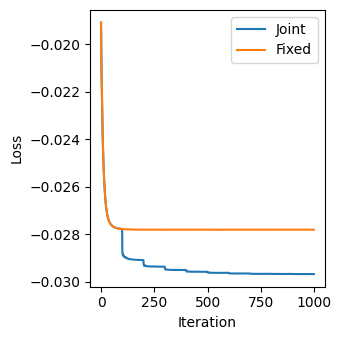

In [123]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
plt.plot(estim_alt.trace, label = "Joint")
plt.plot(estim_fixed.trace, label = "Fixed")
plt.legend()
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("../figures/OU_8D_fitting.pdf")

In [131]:
index = [f"$x_{i+1}$" for i in range(d)]

In [132]:
def fill_diag_nan(A):
    x = np.copy(A)
    np.fill_diagonal(x, np.nan)
    return x

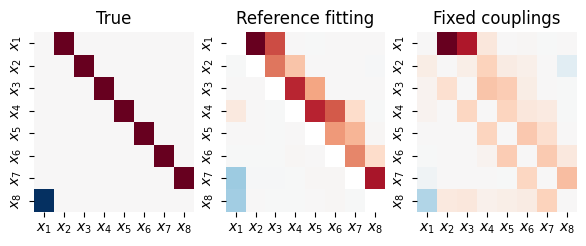

In [133]:
plt.figure(figsize = (2*PLT_CELL, PLT_CELL*2/3))
plt.subplot(1, 3, 2)
sb.heatmap(pd.DataFrame(fill_diag_nan(estim_alt.A), index=index, columns=index), vmin = -10, vmax = 10, cmap = "RdBu_r", cbar = False)
plt.title("Reference fitting")
# plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
# plt.xticks(range(len(index)), index); plt.yticks(range(len(index)), index)
plt.subplot(1, 3, 3)
sb.heatmap(pd.DataFrame(estim_fixed.A, index=index, columns=index), vmin = -10, vmax = 10, cmap = "RdBu_r", cbar = False)
plt.title("Fixed couplings")
# plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
# plt.xticks(range(len(index)), index); plt.yticks(range(len(index)), index)
plt.subplot(1, 3, 1)
sb.heatmap(pd.DataFrame(A_true * (1 - np.eye(A_true.shape[0])), index=index, columns=index), cmap = "RdBu_r", vmin = -1, vmax = 1, cbar = False)
plt.title("True"); 
# plt.gca().xaxis.set_visible(False); plt.gca().yaxis.set_visible(False)
# plt.xticks(range(len(index)), index); plt.yticks(range(len(index)), index)
# plt.tight_layout()
plt.savefig("../figures/OU_8D_nets.pdf")

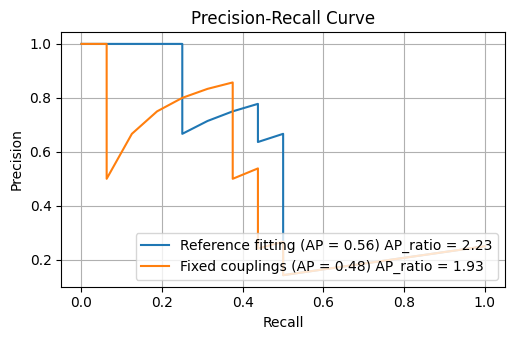

In [134]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = np.abs(np.sign(A_true).astype(int).flatten())
ys["Reference fitting"] = np.abs(estim_alt.A.flatten())
ys["Fixed couplings"] = np.abs(estim_fixed.A.flatten())

plt.figure(figsize=(1.5*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AP = {avg_prec:.2f}) AP_ratio = {avg_prec / y_true.mean():.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc = 'lower right')
plt.grid(True)
plt.tight_layout()
# plt.savefig("../figures/OU_8D_precision.pdf")

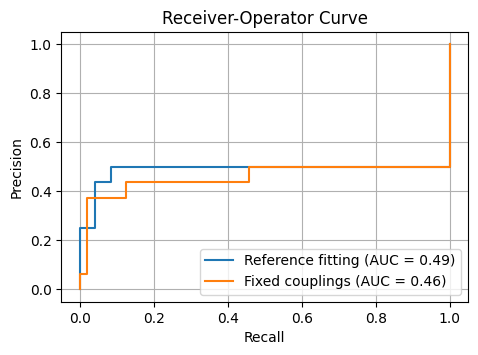

In [135]:
plt.figure(figsize=(1.5*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    fpr, tpr, thresh = roc_curve(y_true, y)
    auc = roc_auc_score(y_true, y)
    plt.plot(fpr, tpr, label=f'{k} (AUC = {auc:.2f})',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Receiver-Operator Curve')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [138]:
T = 10
ys = [estim_alt.Xs[0][i] @ estim_alt.M_pca[0] for i in range(T)]

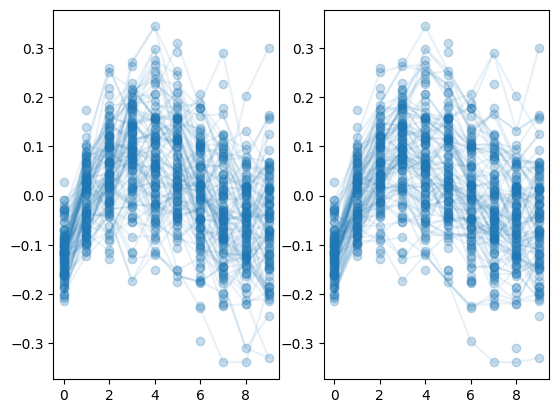

In [139]:
import itertools
from matplotlib.collections import LineCollection
N_paths = 100
dim = 1

x = np.hstack([ys[i][:, dim] for i in range(len(ys))])
t = np.hstack([np.repeat(i, ys[0].shape[0]) for i in range(len(ys))])

plt.subplot(1, 2, 1)
Ts = estim_alt.Ts[0]
plt.scatter(t, x, alpha = 0.25)
lc = []
np.random.seed(0)
for _ in range(N_paths):
    seq = [np.random.randint(Ts[0].shape[0]), ]
    for T in Ts:
        ps = T[seq[-1], :]
        seq.append(np.random.choice(range(T.shape[1]), p = ps / ps.sum()))
    lc.append([(l, ys[l][seq[l], dim].item()) for l in range(len(Ts)+1)])
lc = LineCollection(lc, alpha = 0.1)
plt.gca().add_collection(lc)
plt.subplot(1, 2, 2)
Ts = estim_fixed.Ts[0]
plt.scatter(t, x, alpha = 0.25)
lc = []
np.random.seed(0)
for _ in range(N_paths):
    seq = [np.random.randint(Ts[0].shape[0]), ]
    for T in Ts:
        ps = T[seq[-1], :]
        seq.append(np.random.choice(range(T.shape[1]), p = ps / ps.sum()))
    lc.append([(l, ys[l][seq[l], dim].item()) for l in range(len(Ts)+1)])
lc = LineCollection(lc, alpha = 0.1)
plt.gca().add_collection(lc)

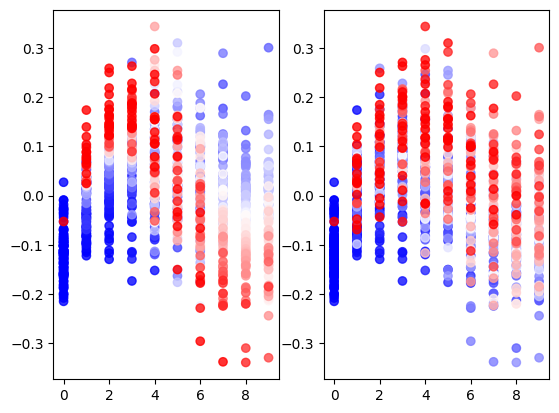

In [140]:
i0 = 0
plt.subplot(1, 2, 1)
Ts = estim_alt.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for T in Ts:
    ps.append((T / T.sum(0)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(t[ord], x[ord], alpha = 0.8, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
plt.subplot(1, 2, 2)
Ts = estim_fixed.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for T in Ts:
    ps.append((T / T.sum(0)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(t[ord], x[ord], alpha = 0.8, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")

In [141]:
x = np.vstack([ys[i] for i in range(len(ys))])
t = np.hstack([np.repeat(i, ys[0].shape[0]) for i in range(len(ys))])

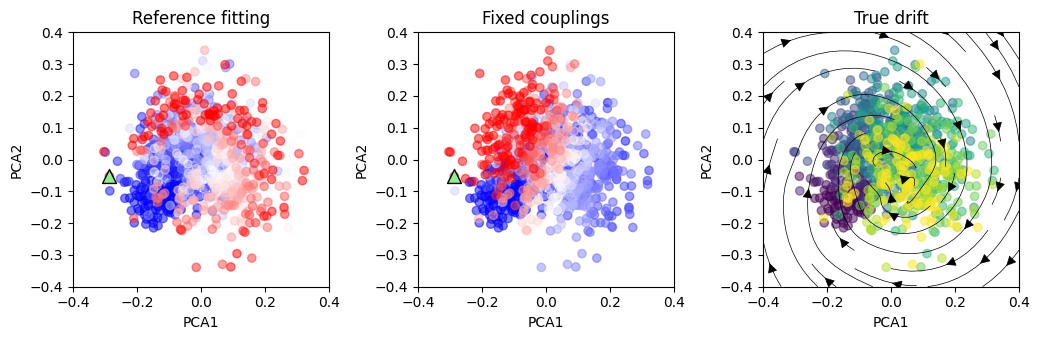

In [149]:
i0 = 0
plt.figure(figsize = (PLT_CELL*3, PLT_CELL))
plt.subplot(1, 3, 1)
Ts = estim_alt.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for _T in Ts:
    ps.append((_T / _T.sum(-1)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(x[ord, 0], x[ord, 1], alpha = 0.5, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
x0 = x[np.where(ps == 1.0)[0][0], :][None, :]
plt.scatter(x0[:, 0], x0[:, 1], color = 'lightgreen', marker = "^", s = 100, edgecolors='k')
plt.ylim(-0.4, 0.4); plt.xlim(-0.4, 0.4)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Reference fitting")
plt.subplot(1, 3, 2)
Ts = estim_fixed.Ts[0]
ps = [1.0*(np.arange(estim_alt.Xs[0][0].shape[0]) == i0), ]
for _T in Ts:
    ps.append((_T / _T.sum(-1)).T @ ps[-1])
ps = np.hstack(ps)
ord = np.argsort(ps)
plt.scatter(x[ord, 0], x[ord, 1], alpha = 0.5, c = ps[ord], vmin = 0, vmax = 0.02, cmap = "bwr")
plt.scatter(x0[:, 0], x0[:, 1], color = 'lightgreen', marker = "^", s = 100, edgecolors='k')
plt.ylim(-0.4, 0.4); plt.xlim(-0.4, 0.4)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Fixed couplings")
plt.subplot(1, 3, 3)
v = xs[0, ...].reshape(-1, d) @ A_true
v = estim_alt.scaler.transform(v) @ estim_alt.M_pca[0].numpy()
plt.scatter(x[:, 0], x[:, 1], c = t, alpha = 0.5)
# plt.quiver(x[:, 0], x[:, 1], v[:, 0], v[:, 1], scale_units = 'xy', scale = 4)
interp_x = sp.interpolate.Rbf(x[:, 0], x[:, 1], v[:, 0])
interp_y = sp.interpolate.Rbf(x[:, 0], x[:, 1], v[:, 1])
X, Y = np.meshgrid(np.linspace(-0.4, 0.4, 10),
                   np.linspace(-0.4, 0.4, 10))
U, V = interp_x(X, Y), interp_y(X, Y)
plt.streamplot(X, Y, U, V, density = 0.5, color = 'k', arrowsize = 1.5, linewidth = 0.5)
plt.ylim(-0.4, 0.4); plt.xlim(-0.4, 0.4)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("True drift")
plt.tight_layout()
plt.savefig("../figures/OU_8D_drifts.pdf")